In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import rosbag
import rospy

import sys
import os
import glob
import pickle
import time
import math
import argparse
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

from plot_verification import *


from bagToCsv import *



In [2]:
def median_filter_1d(signal, window_size):
    filtered_signal = []
    half_window = window_size // 2

    for i in range(len(signal)):
        window = signal[max(0, i - half_window):min(len(signal), i + half_window + 1)]
        sorted_window = sorted(window)
        median_value = sorted_window[len(window) // 2]
        filtered_signal.append(median_value)

    return filtered_signal



In [3]:
def plot_data(df,d):

    ax = plt.figure().add_subplot(projection='3d')

    ax.scatter(df["posx"],df["posy"],df["posz"],color = "red")
    ax.scatter(d[0],d[1],d[2],color = "blue")

    # Make legend, set axes limits and labels
    ax.legend()

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    """    i =1000
    r = R.from_quat([df.qx[i],df.qy[i],df.qz[i],df.qw[i]])
    e =r.as_euler("XYZ")
    ax.quiver(posx[i],posy[i],posz[i],e[0],e[1],e[2],length=0.1,color="blue")"""


In [4]:
def calc_angular_velocities(quat, quat_d):
    w = np.zeros((quat.shape[0], 3))
    for i in range(quat.shape[0]):
        q = quat[i, :]
        q_d = quat_d[i, :]
        a = np.array([[-q[1], -q[2], -q[3]],
                      [q[0], -q[3], q[2]],
                      [q[3], q[0], -q[1]],
                      [-q[2], q[1], q[0]]])
        b = 2*q_d
        w_i = np.linalg.lstsq(a, b, rcond=None)[0]
        w[i, 0], w[i, 1], w[i, 2] = w_i[0], w_i[1], w_i[2]
    return w

In [5]:
def calc_angular_velocities_euler(data):
    euler = [data["eulerx_filter"].values,data["eulery_filter"].values,data["eulerz_filter"].values]
    euler = np.array(euler)
    dt = data["Time"][1]

    w_d = np.zeros(euler.shape)
    i = 0
    while i < 3:
        w_d[:, i] = np.gradient(euler[:, i], dt, edge_order=2)
        i = i+1
    return w_d

In [6]:
def extract_angular_velocities(dataInter):

    time_stamp = dataInter['Time']
    time_stamp = np.array(time_stamp.values.tolist(), dtype=np.float64)
    time_stamp = time_stamp  # converting ms to S

    quat_org = dataInter[['quatw_filter', 'quatx_filter', 'quaty_filter', 'quatz_filter']]
    # quat_org = dataInter[['_vrpnQuat_w', '_vrpnQuat_x', '_vrpnQuat_y', '_vrpnQuat_z']]

    quat_org = np.array(quat_org.values.tolist(), dtype=np.float64)

    quat = quat_org / np.linalg.norm(quat_org, axis=1).reshape(-1, 1)

    quat_d = np.zeros(quat.shape)
    for i in range(quat.shape[1]):
        quat_d[:, i] = np.gradient(quat[:, i], time_stamp, edge_order=2)

    w = calc_angular_velocities(quat, quat_d)
    return w

In [7]:
def transformToolGround(Vquat,Vpos):
        #tool in fct ground
        r = R.from_quat(Vquat)
        p = np.array(Vpos)
        Rot = r.as_matrix()
        T_tool_ground = np.insert(Rot, 3, p, axis=1)

        T_tool_ground = np.insert(T_tool_ground, 3,[0,0,0,1] , axis=0)
        T_tool_ground= np.matrix(T_tool_ground)
        return T_tool_ground


In [8]:
def transformGroundBase(Vpos):

    t = math.pi/2
    Rx = [[1, 0, 0],[0 ,math.cos(t), -math.sin(t)] ,[0 ,math.sin(t), math.cos(t)] ]
    Rx= np.matrix(Rx)

    t = math.pi/2
    Ry = [[math.cos(t),0, math.sin(t)],[0 ,1,0] ,[-math.sin(t),0, math.cos(t)] ]
    Ry= np.matrix(Ry)

    Rtot = Rx

    T_ground_Base = np.insert(Rtot, 3, Vpos, axis=1)
    T_ground_Base = np.insert(T_ground_Base, 3,[0,0,0,1] , axis=0)

    return T_ground_Base


In [9]:
def transformBaseEef(stringTransform , t):

    Rx = [[1, 0, 0],[0 ,math.cos(t), -math.sin(t)] ,[0 ,math.sin(t), math.cos(t)] ]
    Ry = [[math.cos(t),0, math.sin(t)],[0 ,1,0] ,[-math.sin(t),0, math.cos(t)] ]
    Rz = [[math.cos(t), -math.sin(t), 0],[math.sin(t), math.cos(t),0] ,[0 ,0,1] ]

    Ry= np.matrix(Ry)
    Rz= np.matrix(Rz)
    Rx= np.matrix(Rx)
    
    if stringTransform == "x":
        Rtot = Rx
    if stringTransform == "y":
        Rtot = Ry
    if stringTransform == "z":
        Rtot = Rz

    T_tool_eef = np.insert(Rtot, 3,[0,0,0], axis=1)
    T_tool_eef = np.insert(T_tool_eef, 3,[0,0,0,1] , axis=0)
    return T_tool_eef


In [10]:
def take_target(file_name):
    for i in range(10):
        target= "target" + str(i+1)
        if not ((file_name.find(target)==-1)):
            break

    return target

In [11]:
def extractQuatPos (T):
    condition = [[0, 0, 0,1],[0, 0, 0,1],[0, 0, 0,1],[0,0,0,0] ]
    pos_opt_world =  np.extract(condition, T)

    condition = [[1, 1, 1,0],[1, 1, 1,0],[1, 1, 1,0],[0,0,0,0] ]
    R_opt_world =  np.matrix(np.extract(condition, T).reshape((3, 3)))
    R_opt_world = R.from_matrix(R_opt_world)
    quat_opt_world  = R_opt_world.as_quat()
    euler_opt_world = R_opt_world.as_euler("XYZ")

    return quat_opt_world, pos_opt_world, euler_opt_world

In [12]:
def take_pos_target(numberTarget):
    targetPath = "../targets/" + numberTarget + ".csv"
    dataTarget = pd.read_csv(targetPath)
    quatxTarget = dataTarget["X"].values
    quatyTarget = dataTarget["Y"].values
    quatzTarget = dataTarget["Z"].values
    quatwTarget = dataTarget["W"].values
    posxTarget = dataTarget["X.1"].values
    posyTarget  = dataTarget["Y.1"].values
    poszTarget  = dataTarget["Z.1"].values
    quatTarg = [np.mean(quatxTarget),np.mean(quatyTarget),np.mean(quatzTarget),np.mean(quatwTarget)] 
    posTarg  = [np.mean(posxTarget) ,np.mean(posyTarget) ,np.mean(poszTarget) ]

    return quatTarg,posTarg

In [13]:
def transformTarget(quatTarget, posTarget,dataInter):

        #tool in fct ground
        T_tool_ground = transformToolGround(quatTarget,posTarget)

        # ground in function of base
        p =[0,0,0]
        T_ground_Base =  transformGroundBase(p)
        T_tilt = T_ground_Base* T_tool_ground  
        quat_opt_world , pos_opt_world, e = extractQuatPos(T_tilt)

        return  quat_opt_world , pos_opt_world
  

In [14]:
def add_target_dataframe(Name, data, Disp):
    #compute target pos
    t = take_target(Name)
    if t != "target9" and t != "target10": 

        QuatTarget, a = take_pos_target(t)
        PosTarget = [0,0,0]
        QuatTarget, PosTarget = transformTarget(QuatTarget, PosTarget, data)
        PosTarget = PosTarget + Disp
        data["quatwTarget"] = '-'
        data["quatxTarget"] = '-'
        data["quatyTarget"] = '-'
        data["quatzTarget"] = '-' 

        data["posxTarget"] = '-'
        data["posyTarget"] = '-'
        data["poszTarget"] = '-' 

        data["quatwTarget"][0] = QuatTarget[3] 
        data["quatxTarget"][0] = QuatTarget[0]
        data["quatyTarget"][0] = QuatTarget[1]
        data["quatzTarget"][0] = QuatTarget[2] 


        data["posxTarget"][0] = PosTarget[0]
        data["posyTarget"][0] = PosTarget[1]
        data["poszTarget"][0] = PosTarget[2]
        return data 

In [15]:
def clean_force_and_add_to_dataframe(datainter,datafinal):
    wSize=30
    datafinal["forcex"] = datainter["_ftforce_x"]
    datafinal["forcey"] = datainter["_ftforce_y"]
    datafinal["forcez"] = datainter["_ftforce_z"]
    datafinal["forcex_filter"] = median_filter_1d(datainter["_ftforce_x"], wSize)
    datafinal["forcey_filter"] = median_filter_1d(datainter["_ftforce_y"], wSize)
    datafinal["forcez_filter"] = median_filter_1d(datainter["_ftforce_z"], wSize)

    datafinal["torquex"] = datainter["_fttorque_x"]
    datafinal["torquey"] = datainter["_fttorque_y"]
    datafinal["torquez"] = datainter["_fttorque_z"]

    datafinal["torquex_filter"] = median_filter_1d(datainter["_fttorque_x"], wSize)
    datafinal["torquey_filter"] = median_filter_1d(datainter["_fttorque_y"], wSize)
    datafinal["torquez_filter"] = median_filter_1d(datainter["_fttorque_z"], wSize)


    

    return datafinal

In [25]:
def transform_data(dataInitial,Name,Disp,task):
    wSize = 30

    dataInter = dataInitial
    posx= []
    posy= []
    posz= []

    quat_x =[]
    quat_y =[]
    quat_z =[]
    quat_w =[]

    eulerx = []
    eulery = []
    eulerz = []

    qx= []
    qy= []
    qz= []
    qw= []
    i = 0
    while i < len(dataInter):

        #Center to the center of the targer
        t = take_target(Name)
        qTa, pTar = take_pos_target(t)
            
        #tool in fct ground
        quatTarget = [dataInter["_vrpnQuat_x"][i],dataInter["_vrpnQuat_y"][i],dataInter["_vrpnQuat_z"][i],dataInter["_vrpnQuat_w"][i]]
        posTarget  = [dataInter["_vrpnPos_x"][i]- pTar[0],dataInter["_vrpnPos_y"][i]-pTar[1],dataInter["_vrpnPos_z"][i]-pTar[2]]
        T_tool_ground = transformToolGround(quatTarget,posTarget)


        # ground in function of base
        p = [0,0,0]
        #p = [-np.mean(dataInter["_vrpnPos_z"]),-np.mean(dataInter["_vrpnPos_x"])+0.6,1]
        T_ground_Base =  transformGroundBase(p)

        #quat of the tools in function of the iiwa tools
    
        if task == 0:
            T_tool_eef = transformBaseEef("x", -math.pi/2)
        else:
            T_tool_eef = transformBaseEef("y", math.pi)


        T_tilt = T_ground_Base* T_tool_ground* T_tool_eef

        #extractt quat,pos and euler from Transformation matrix
        quat_opt_world , pos_opt_world, euler_opt_world = extractQuatPos(T_tilt)

        posx.append(pos_opt_world[0]+ Disp[0])
        posy.append(pos_opt_world[1]+ Disp[1])
        posz.append(pos_opt_world[2]+ Disp[2])
        eulerx.append(euler_opt_world[0])
        eulery.append(euler_opt_world[1])
        eulerz.append(euler_opt_world[2])
        qx.append(quat_opt_world[0])
        qy.append(quat_opt_world[1])
        qz.append(quat_opt_world[2])
        qw.append(quat_opt_world[3])

        i= 1+i
        
 

    #replace the position of the target on the robot frame
    #Prepare csvfile
    data_df_T = pd.DataFrame()
    
    data_df_T["Time"]  = dataInter['Time']
    data_df_T["dt"]    = dataInter['dt']
    data_df_T["quatx"] = qx
    data_df_T["quaty"] = qy
    data_df_T["quatz"] = qz
    data_df_T["quatw"] = qw
    data_df_T["quatx_filter"] = median_filter_1d(qx, wSize)
    data_df_T["quaty_filter"] = median_filter_1d(qy, wSize)
    data_df_T["quatz_filter"] = median_filter_1d(qz, wSize)
    data_df_T["quatw_filter"] = median_filter_1d(qw, wSize)


    data_df_T["posx"] = posx 
    data_df_T["posy"] = posy 
    data_df_T["posz"] = posz 
    data_df_T["eulerx"] = eulerx
    data_df_T["eulery"] = eulery
    data_df_T["eulerz"] = eulerz
    data_df_T["eulerx_filter"] = median_filter_1d(eulerx, wSize) 
    data_df_T["eulery_filter"] = median_filter_1d(eulery, wSize) 
    data_df_T["eulerz_filter"] = median_filter_1d(eulerz, wSize) 

    # compute angular velocity
    w = extract_angular_velocities(data_df_T)
    w_euler= calc_angular_velocities_euler(data_df_T)

    data_df_T["wx"] = w[:, 0]
    data_df_T["wy"] = w[:, 1]
    data_df_T["wz"] = w[:, 2]

    data_df_T["wx_filter"] = median_filter_1d( w[:, 0], wSize)
    data_df_T["wy_filter"] = median_filter_1d( w[:, 1], wSize)
    data_df_T["wz_filter"] = median_filter_1d( w[:, 2], wSize)

    if task == 1:
        data_df_T =clean_force_and_add_to_dataframe(dataInter,data_df_T)



    #compute target pos
    data_df_T = add_target_dataframe(Name, data_df_T, Disp)

    nameFinal = "../csv_transform_robot/" + Name
    data_df_T.to_csv(nameFinal, index= None )
    return data_df_T    
    

In [17]:
def transform_data_surf(dataInitial,Name,Disp):
    wSize =5
    dataInter = dataInitial
    posx= []
    posy= []
    posz= []

    quat_x =[]
    quat_y =[]
    quat_z =[]
    quat_w =[]

    eulerx = []
    eulery = []
    eulerz = []

    qx= []
    qy= []
    qz= []
    qw= []
    i = 0
    while i < len(dataInter):

        #Center to the center of the targer
        t = take_target(Name)
        qTa, pTar = take_pos_target(t)
        p  = [pTar[0],pTar[1],pTar[2]]
        #tool in fct ground
        quatTarget = [dataInter["_vrpnQuat_x"][i],dataInter["_vrpnQuat_y"][i],dataInter["_vrpnQuat_z"][i],dataInter["_vrpnQuat_w"][i]]
        posTarget  = [dataInter["_vrpnPos_x"][i]- pTar[0],dataInter["_vrpnPos_y"][i]-pTar[1],dataInter["_vrpnPos_z"][i]-pTar[2]]
        T_tool_ground = transformToolGround(quatTarget,posTarget)


        # ground in function of base
        p = [0,0,0]
        #p = [-np.mean(dataInter["_vrpnPos_z"]),-np.mean(dataInter["_vrpnPos_x"])+0.6,1]
        T_ground_Base =  transformGroundBase(p)

        #quat of the tools in function of the iiwa tools
    
        T_tool_eef = transformBaseEef("y", math.pi)

        T_tilt = T_ground_Base* T_tool_ground * T_tool_eef

        #extractt quat,pos and euler from Transformation matrix
        quat_opt_world , pos_opt_world, euler_opt_world = extractQuatPos(T_tilt)

        posx.append(pos_opt_world[0]+ Disp[0])
        posy.append(pos_opt_world[1]+ Disp[1])
        posz.append(pos_opt_world[2]+ Disp[2])
        eulerx.append(euler_opt_world[0])
        eulery.append(euler_opt_world[1])
        eulerz.append(euler_opt_world[2])
        qx.append(quat_opt_world[0])
        qy.append(quat_opt_world[1])
        qz.append(quat_opt_world[2])
        qw.append(quat_opt_world[3])

        i= 1+i
        
    # compute angular velocity

    #replace the position of the target on the robot frame

    #Prepare csvfile
    data_df_T = pd.DataFrame()

    data_df_T["Time"] = dataInter['Time']
    data_df_T["dt"] = abs(dataInter['dt'].values)

    data_df_T["quatx"] = qx
    data_df_T["quaty"] = qy
    data_df_T["quatz"] = qz
    data_df_T["quatw"] = qw
    data_df_T["quatx_filter"] = median_filter_1d(qx, wSize)
    data_df_T["quaty_filter"] = median_filter_1d(qy, wSize)
    data_df_T["quatz_filter"] = median_filter_1d(qz, wSize)
    data_df_T["quatw_filter"] = median_filter_1d(qw, wSize)

    data_df_T["posx"] = posx 
    data_df_T["posy"] = posy 
    data_df_T["posz"] = posz 
    data_df_T["eulerx"] = eulerx 
    data_df_T["eulery"] = eulery 
    data_df_T["eulerz"] = eulerz

    w = extract_angular_velocities(data_df_T)
    data_df_T["wx"] = w[:, 0]
    data_df_T["wy"] = w[:, 1]
    data_df_T["wz"] = w[:, 2]
    data_df_T["wx_filter"] = median_filter_1d( w[:, 0], wSize)
    data_df_T["wy_filter"] = median_filter_1d( w[:, 1], wSize)
    data_df_T["wz_filter"] = median_filter_1d( w[:, 2], wSize)


    data_df_T =clean_force_and_add_to_dataframe(dataInter,data_df_T)

    #compute target pos
    data_df_T = add_target_dataframe(Name, data_df_T, Disp)


    nameFinal = "../csv_transform_robot/" + Name
    data_df_T.to_csv(nameFinal, index= None )
    return data_df_T    
    

In [18]:
# Create all csv files from .bag
bagshot = glob.glob('../csv/*shot.bag')
for name in bagshot:
    name =name.removesuffix('.bag') 
    bagToCsv(name,0)
bagsurf = glob.glob('../csv/*surf.bag')
for name in bagsurf:
    name =name.removesuffix('.bag') 
    bagToCsv(name,1)


In [26]:
surfPandas= []
shotPandas= []

"""shot = glob.glob('../csv/*shot.csv')
for i in range(len(shot)):
    file_name = shot[i]
    data = pd.read_csv(file_name, index_col=False)
    file_name_short= file_name.replace("../csv/", "")
    print(file_name_short)
    displacementFromTarget = [1.25,0,0.7] 
    data_final= transform_data(data,file_name_short,displacementFromTarget,0)
    shotPandas.append(data_final)"""
surf = glob.glob('../csv/*surf.csv')
for i in range(len(surf)):
    file_name_surf = surf[i]
    data = pd.read_csv(file_name_surf, index_col=False)
    file_name_short= file_name_surf.replace("../csv/", "")
    print(file_name_short)
    displacementFromTarget = [0.5,0,0.7]  
    data_final=transform_data(data,file_name_short,displacementFromTarget,1)
    surfPandas.append(data_final)


subject1_target2_trial2_surf.csv
subject3_target3_trial1_surf.csv
subject1_target1_trial1_surf.csv
subject3_target8_trial2_surf.csv
subject2_target8_trial1_surf.csv
subject2_target7_trial1_surf.csv
subject1_target5_trial2_surf.csv
subject3_target7_trial1_surf.csv
subject3_target4_triall_surf.csv
subject1_target6_trial2_surf.csv
subject3_target8_trial1_surf.csv
subject2_target4_trial1_surf.csv
subject2_target3_trial1_surf.csv
subject1_target1_trial2_surf.csv


In [20]:
# With vrpn_transfom we have everything with the conventional axe XYZ with Z on the top. 
# Now we need to transform this to the foot of the iiwa and then make another transform for the orientation of the tool and the iwwa
# The target has the size 50x50x4 and the ground_optitrack was on the top of the target.

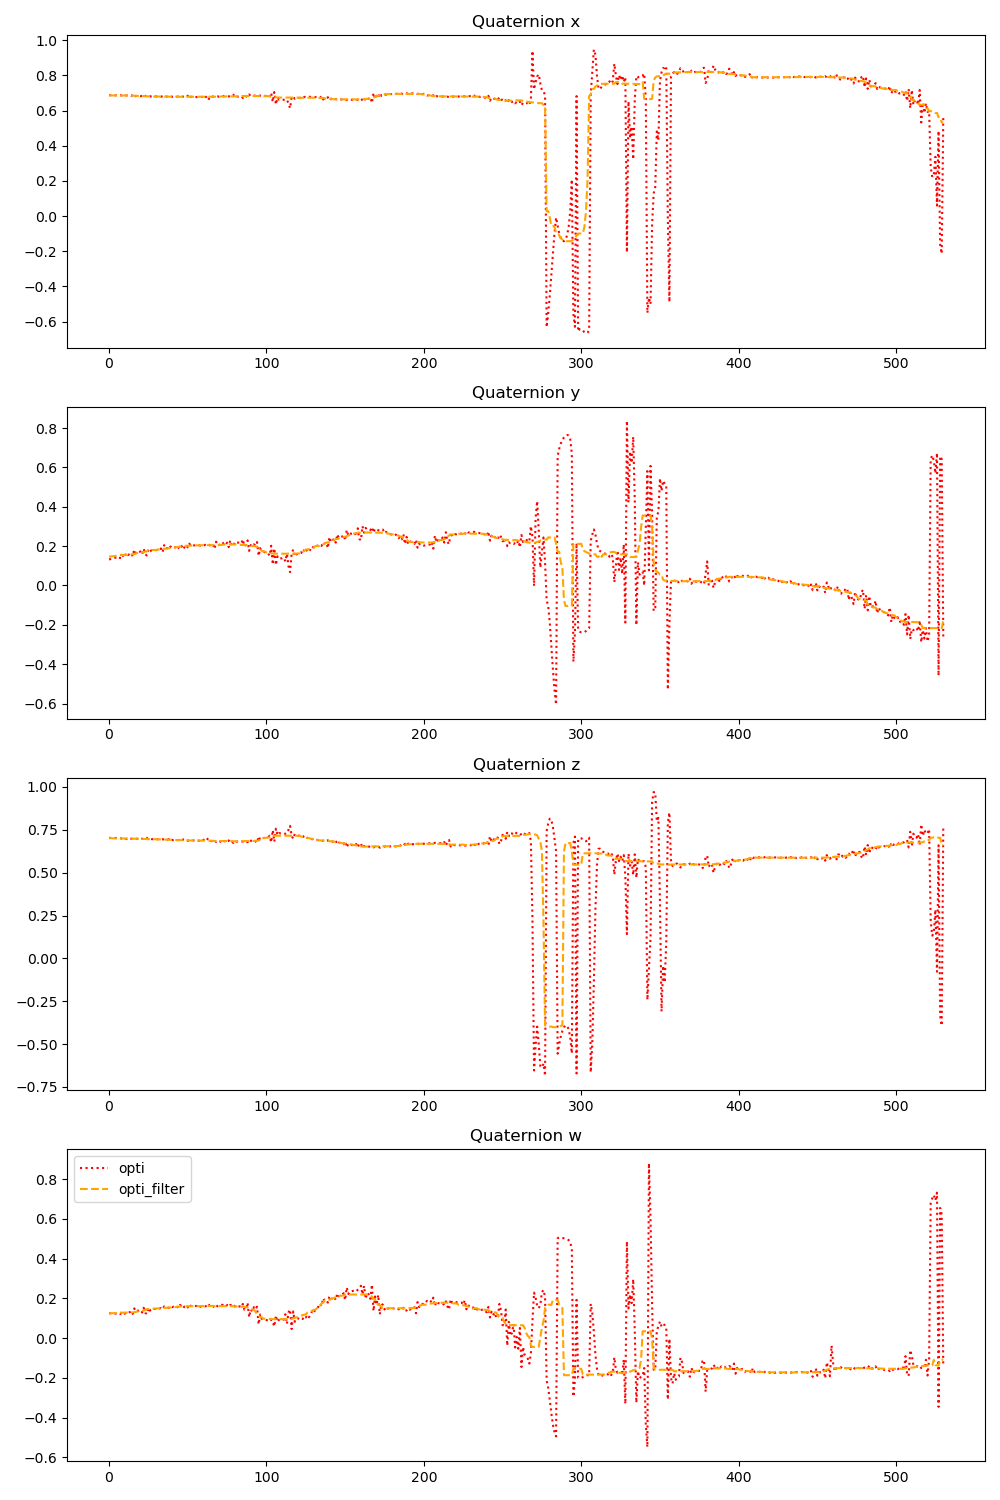

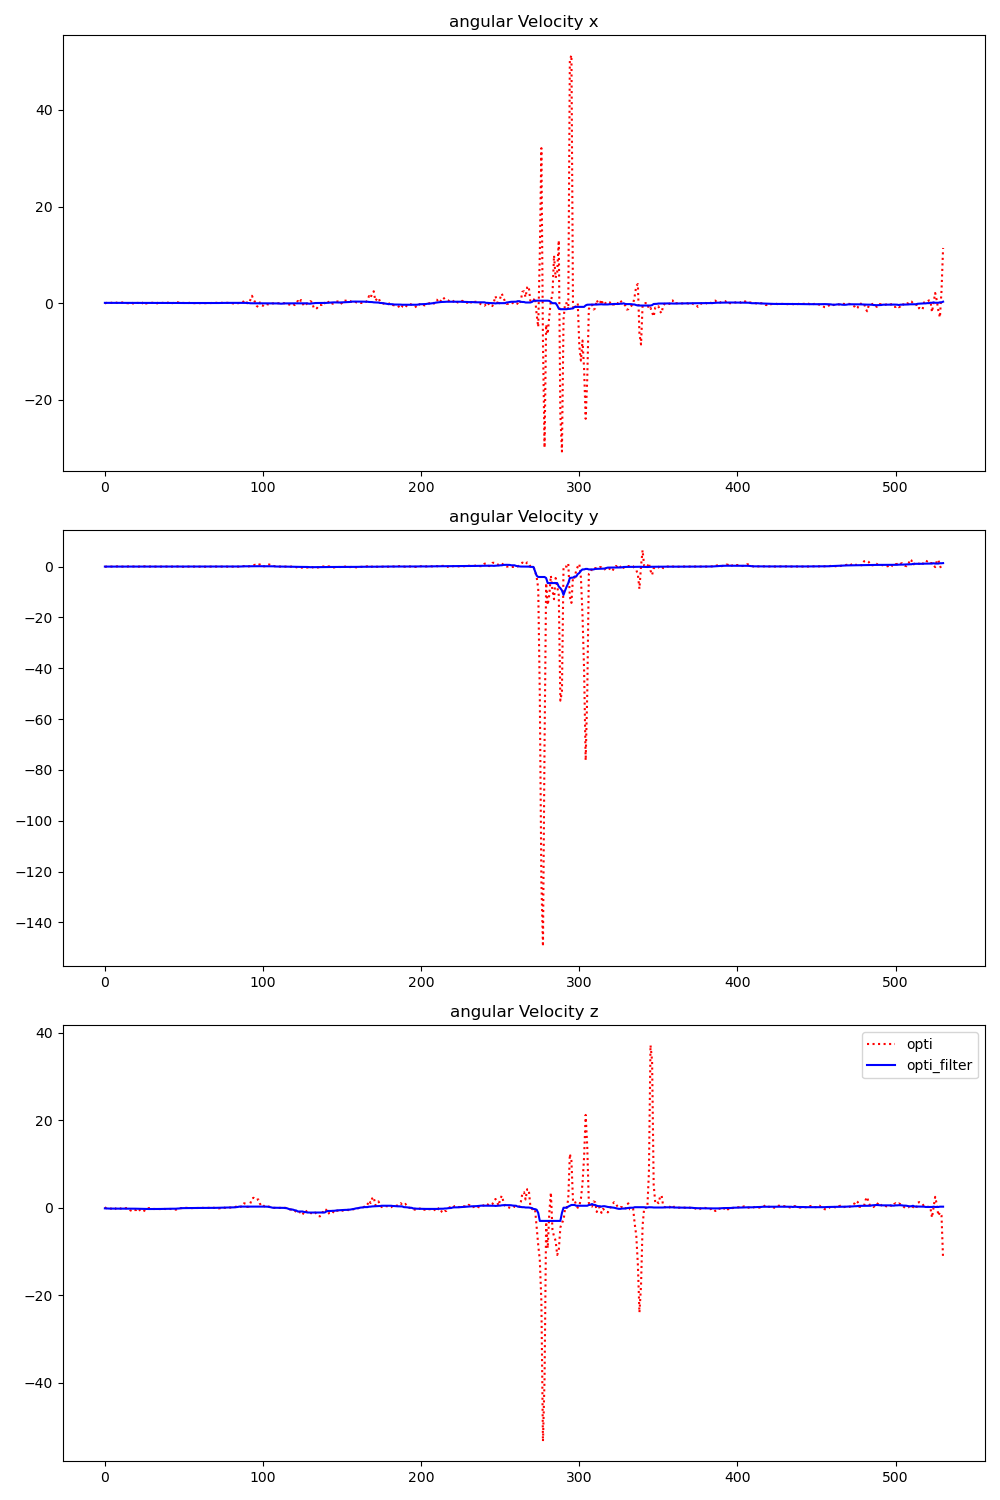

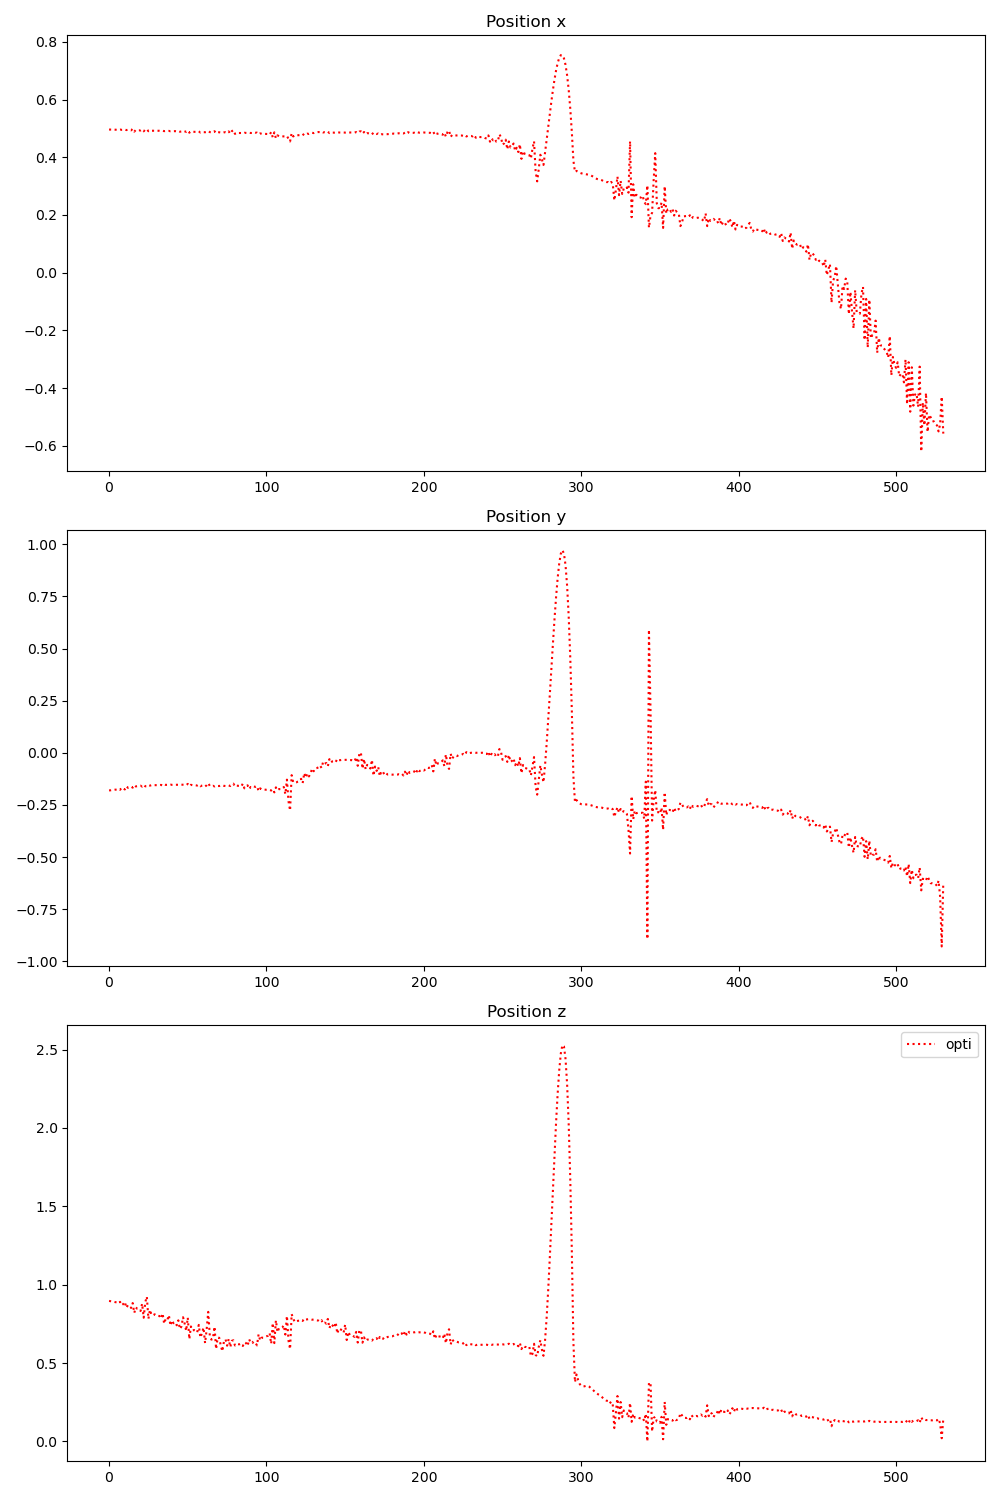

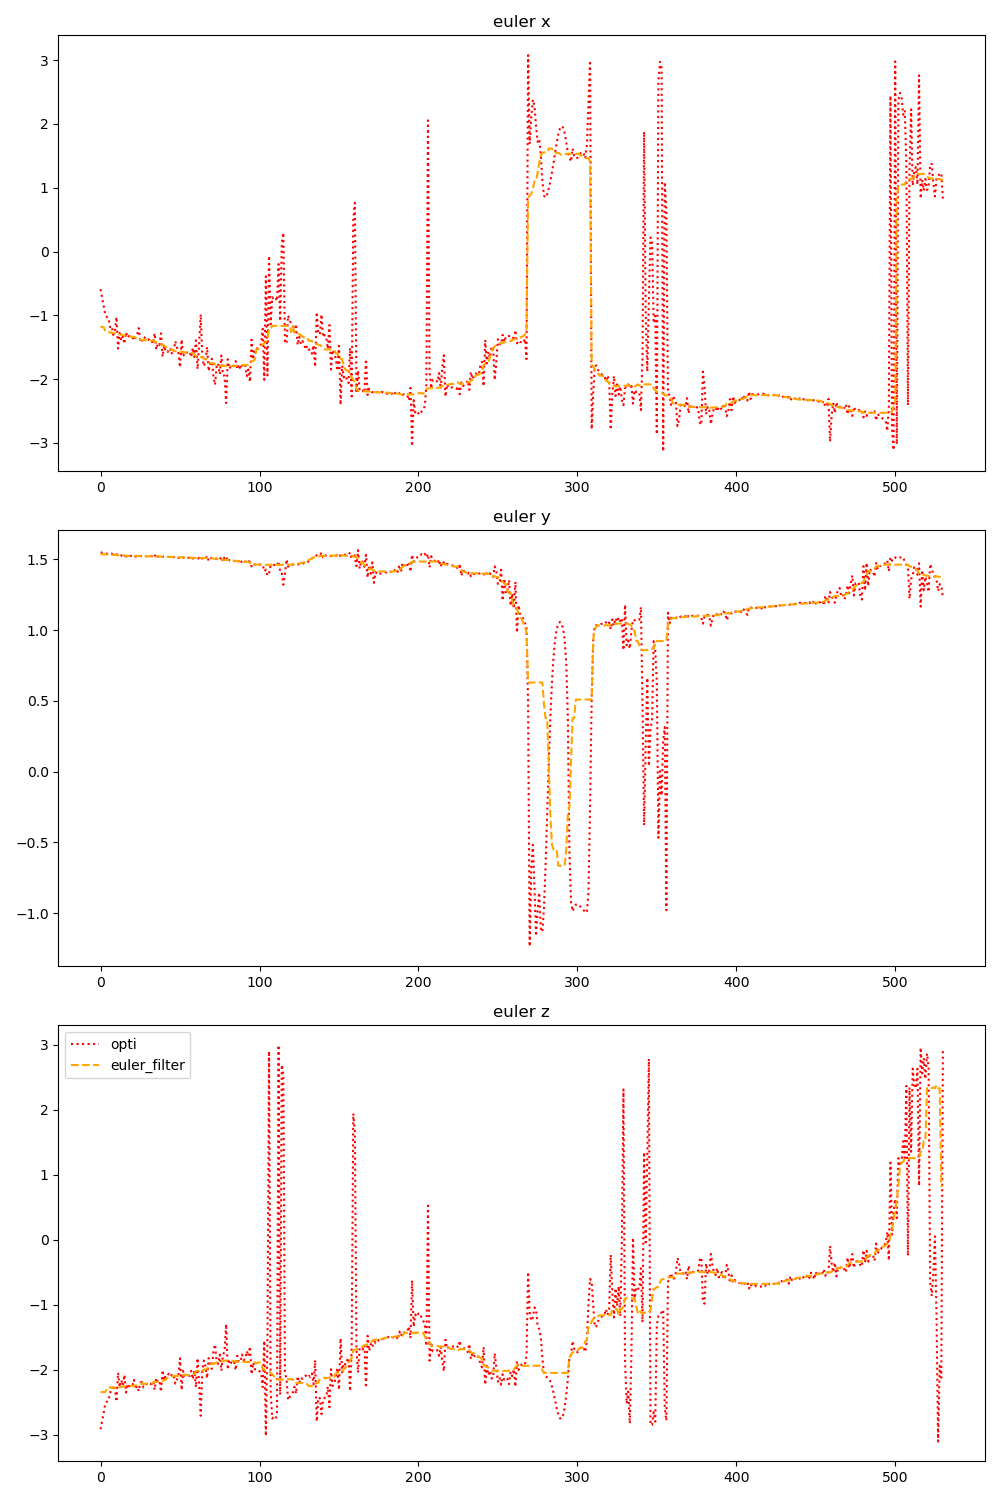

no Data
no Data
         Time        dt     quatx     quaty     quatz     quatw  quatx_filter  \
0    0.000000  0.008906  0.687922  0.131876  0.702575  0.125540      0.686762   
1    0.008906  0.008906  0.687633  0.134350  0.702425  0.125342      0.686748   
2    0.017813  0.008906  0.687530  0.136654  0.702136  0.125030      0.686748   
3    0.026719  0.008906  0.687776  0.138481  0.701783  0.123646      0.686644   
4    0.035625  0.008906  0.686976  0.140899  0.701981  0.124234      0.686644   
..        ...       ...       ...       ...       ...       ...           ...   
526  4.684736  0.008906  0.060068  0.673457 -0.077841  0.732658      0.586891   
527  4.693642  0.008906  0.484733 -0.458666  0.659900 -0.345241      0.562590   
528  4.702549  0.008906 -0.161340  0.656880 -0.335865  0.655494      0.562590   
529  4.711455  0.008906 -0.213539  0.642254 -0.391913  0.623149      0.532811   
530  4.720361  0.008906  0.562590 -0.262660  0.770642 -0.143572      0.532811   

     quaty_

In [24]:
i = 2

data = glob.glob('../csv_transform_robot/*surf.csv')
file_name = data[i]
data_final = pd.read_csv(file_name, index_col=False)

plot_quaternion(data_final)
plot_angularVelocity(data_final)
plot_position(data_final)
plot_euler(data_final)
plot_force(data_final)
plot_torque(data_final)
print(data_final)

## plot

In [22]:
shot = glob.glob('../csv/*shot.csv')

i = 2
file_name = shot[i]
data = pd.read_csv(file_name, index_col=False)
file_name_short= file_name.replace("../csv/", "")
print(file_name_short)
displacementFromTarget = [1.25,0,0.7] 
data_final= transform_data_shot(data,file_name_short,displacementFromTarget)

plot_quaternion(data_final)
plot_angularVelocity(data_final)
plot_position(data_final)
plot_euler(data_final)
print(data_final)
"""
surf = glob.glob('../csv/*surf.csv')
for i in range(len(surf)):
    file_name_surf = surf[i]
    data = pd.read_csv(file_name_surf, index_col=False)
    file_name_short= file_name_surf.replace("../csv/", "")
    print(file_name_short)
    displacementFromTarget = [0.5,0,0.7]  
    transform_data_surf(data,file_name_short,displacementFromTarget)"""

subject2_target4_trial1_shot.csv


NameError: name 'transform_data_shot' is not defined

In [ ]:
data_final.plot(y= "wx_filter")
data_final.plot(y= "wx_euler")
data_final.plot(y= "wx")



In [ ]:
def plot_3d_with_target(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['posx'], df['posy'], df['posz'])
    euler = [df['eulerx'], df['eulery'], df['eulerz']]

    i = 500
    posx = df['posx'].values[i]
    posy = df['posy'].values[i]
    posz = df['posz'].values[i]
    e = [df['eulerx'].values[i],df['eulery'].values[i],df['eulerz'].values[i]]

    ax.quiver(posx,posy,posz,e[0],e[1],e[2],length=0.5,color="red")
    q = [df['posxTarget'].values[0], df['posyTarget'].values[0], df['poszTarget'].values[0]]
    q = np.array(q,dtype=float)
    ax.scatter(q[0],q[1],q[2],c="yellow", s = 200)
    ax.scatter(0,0,0,c="red")

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    plt.show()


In [ ]:
def plot_3d(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['_vrpnPos_x'], df['_vrpnPos_y'], df['_vrpnPos_z'])
        
    ax.scatter(0,0,0,c="red")


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    plt.show()

In [ ]:
files = glob.glob('../csv_transform_robot/*shot.csv')
print(files)
file_name= files[6]


print(file_name)
data = pd.read_csv(file_name, index_col=False)

plot_3d_with_target(data,)

In [ ]:
files = glob.glob('../csv_transform_robot/*surf.csv')
file_name= files[1]

print(file_name)
data = pd.read_csv(file_name, index_col=False)

plot_3d_with_target(data)